# Spatial light Modulator (SLM) as XY vector mask

This notebook demonstrates how to use a Spatial Light Modulator (SLM) as an XY vector mask. The SLM is a device that can modulate the phase of light in two dimensions. This allows for the creation of complex light patterns that can be used for various applications such as optical trapping, holography, and microscopy. In this notebook, we will use the SLM to create a simple XY vector mask that can be used to generate a light pattern with a specific intensity profile.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from py_pol.jones_vector import Jones_vector
from py_pol.jones_matrix import Jones_matrix

In [3]:
from diffractio import np, plt, sp
from diffractio import degrees, mm, um

from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.vector_masks_XY import Vector_mask_XY

from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.vector_sources_XY import Vector_source_XY

## Py_pol acquisition of the Jones matrix of the SLM



In [4]:
# Load the Jones calibration matrix of the SLM
SLM_matrix = np.load('calibration_slm_jones_2500.npz')
print(SLM_matrix.files)
j0 = SLM_matrix['J0']*np.exp(1j*SLM_matrix['d0'])
j1 = SLM_matrix['J1']*np.exp(1j*SLM_matrix['d1'])
j2 = SLM_matrix['J2']*np.exp(1j*SLM_matrix['d2'])
j3 = SLM_matrix['J3']*np.exp(1j*SLM_matrix['d3'])


['J0', 'J1', 'J2', 'J3', 'd0', 'd1', 'd2', 'd3']


The matrix components of SLM are:
The mean value of param J00 is (0.5272662017470633+0.3090238226182662j) +- 0.19510017460538737
The mean value of param J01 is (-0.16498867546125978+0.06380249535487544j) +- 0.16730177122338893
The mean value of param J10 is (-0.31308465044425227+0.13854361763991407j) +- 0.37747574458954225
The mean value of param J11 is (-0.12638982293142742-0.08363420560713405j) +- 0.5866856430837512


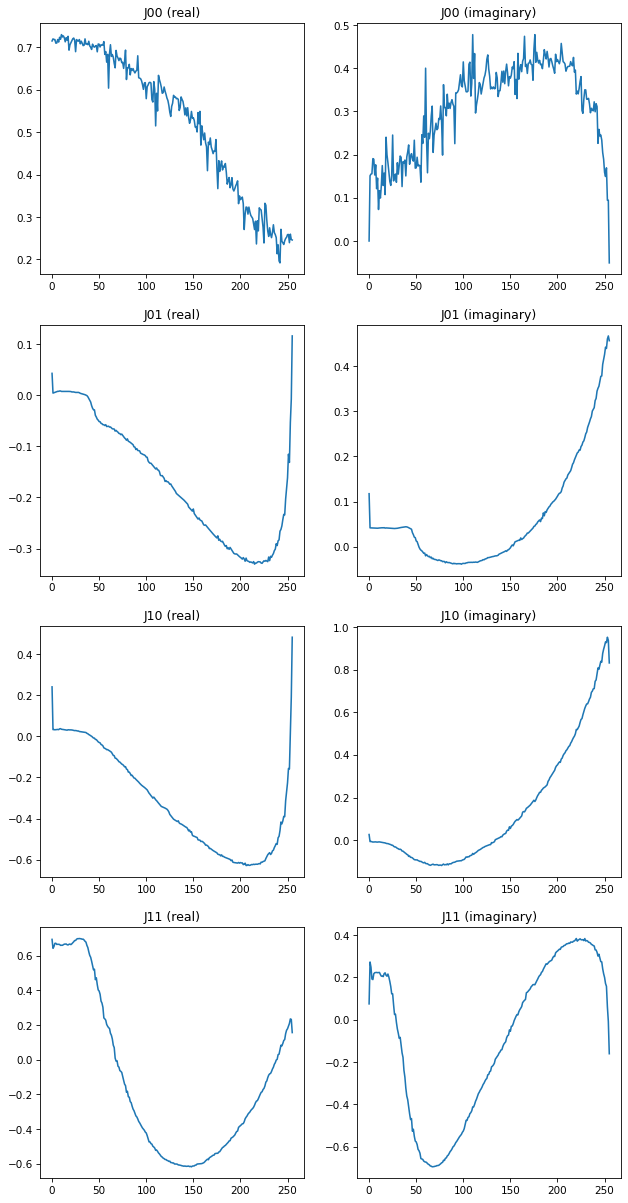

In [5]:
# Convert the calibration matrix to a py_pol Jones matrix
states_jones = Jones_matrix('SLM')
states_jones.from_components([j0, j1, j2, j3])
states_jones.draw(verbose=False)

# Pass to Vector_mask_XY

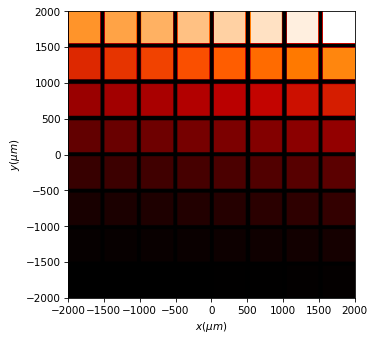

In [6]:
# Define the mask, as 0-255 values (gray levels)

x = np.linspace(-2*mm, 2*mm, 1024)
y = np.linspace(-2*mm, 2*mm, 1024)
wavelength = 0.6328*um

SLM1_scalar = Scalar_mask_XY(x=x, y=y, wavelength=wavelength)
SLM1_scalar.squares_nxm(num_levels=64, border_size=50*um)
SLM1_scalar.draw('intensity')

<Figure size 480x360 with 0 Axes>

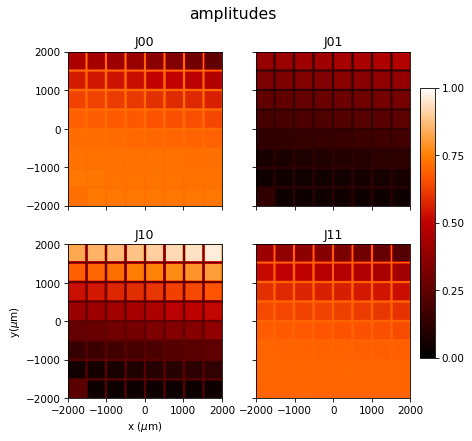

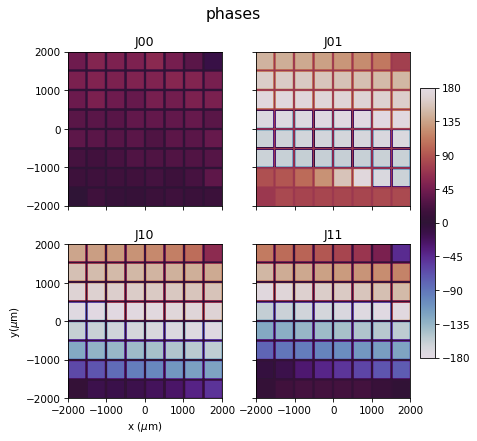

In [7]:
SLM1_vector = Vector_mask_XY(x=x, y=y, wavelength=wavelength)
SLM1_vector.SLM(SLM1_scalar, states_jones)
SLM1_vector.draw(kind='jones_ap')

## Example with a lens

In [8]:
s0 = Jones_vector().linear_light(azimuth=90*degrees)
s_phase = states_jones*s0

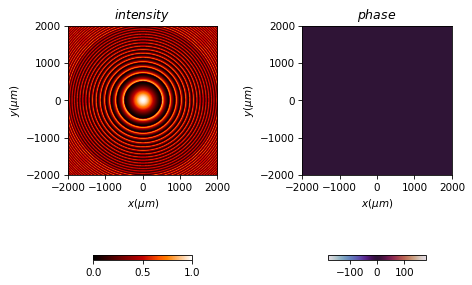

In [25]:
# Define the mask, as 0-255 values (gray levels)

x = np.linspace(-2*mm, 2*mm, 1024)
y = np.linspace(-2*mm, 2*mm, 1024)
wavelength = 0.6328*um

SLM1_scalar = Scalar_mask_XY(x=x, y=y, wavelength=wavelength)
SLM1_scalar.lens(r0=(0*um, 0*um), focal=200*mm)
SLM1_scalar.pupil()
phase = np.angle(SLM1_scalar.u)
amplitude = phase/(2*np.pi)+0.5
SLM1_scalar.u = amplitude
SLM1_scalar.draw('field', percentage_intensity=0.01)

<Figure size 480x360 with 0 Axes>

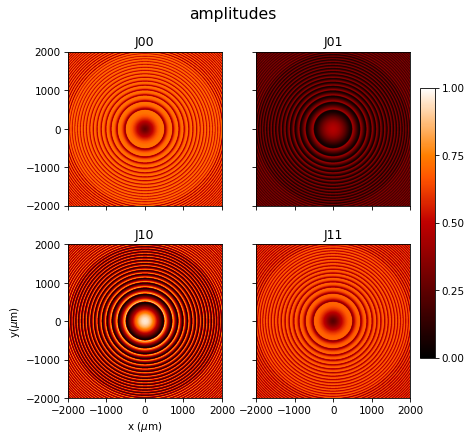

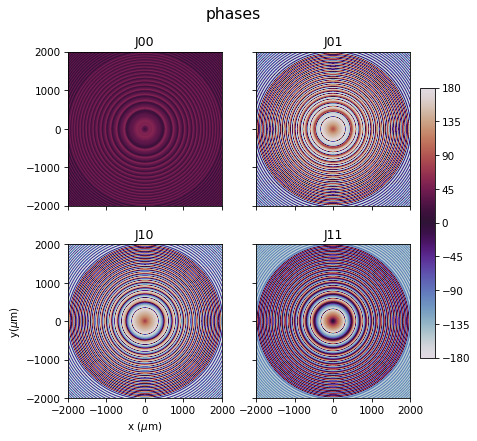

In [10]:
SLM1_vector = Vector_mask_XY(x=x, y=y, wavelength=wavelength)
SLM1_vector.SLM(SLM1_scalar, states_jones)
SLM1_vector.draw(kind='jones_ap')

## Propagation of the light field

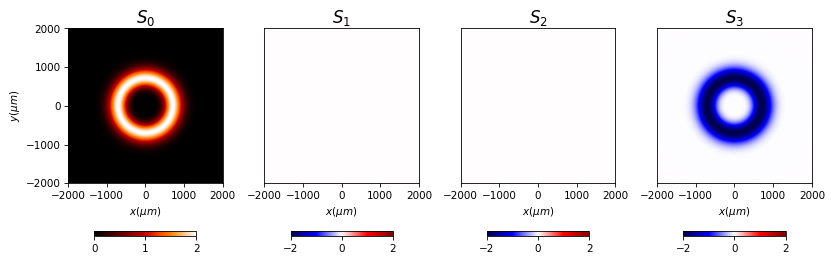

In [11]:
# Light source

u0 = Scalar_source_XY(x=x, y=y, wavelength=wavelength)
u0.vortex_beam(r0=(0*um, 0*um), A=1, w0=.5*mm,  m=4)
u0.pupil(radius=2*mm)

S0 = Vector_source_XY(x=x, y=y, wavelength=wavelength)
S0.constant_polarization(u=u0, v=(1,1j))
S0.draw(kind='stokes')



In [12]:
# Light through the SLM and the polarizers
E1 = S0 *  SLM1_vector 

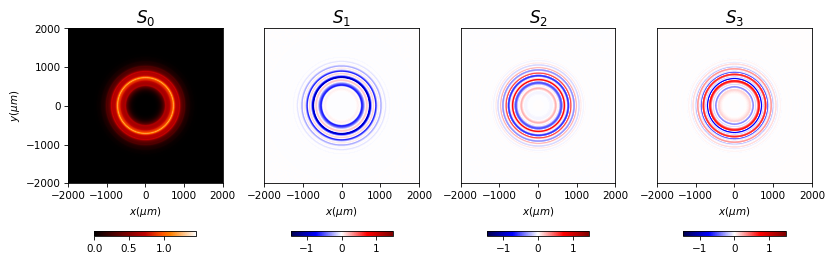

In [13]:
E1.draw(kind='stokes')

In [14]:
xout = np.linspace(-1000*um, 1000*um, 512)
yout = np.linspace(-1000*um, 1000*um, 512)
E_final = E1.VCZT(z=300*mm, xout=xout, yout=yout)
E_final.normalize()

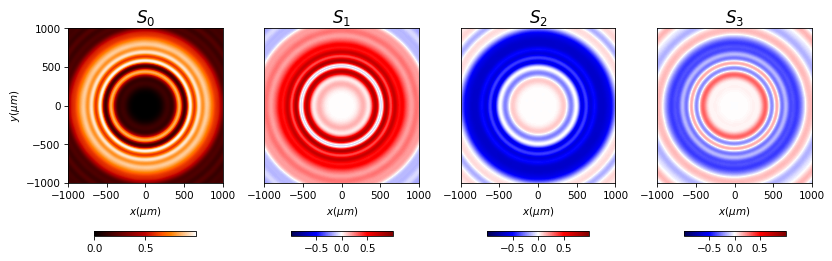

In [15]:
E_final.draw(kind='stokes', logarithm=0)

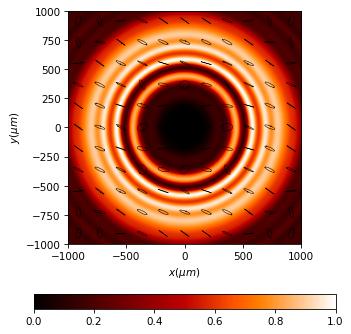

In [24]:
E_final.draw(kind='ellipses', color_line="k")

## Result to py_pol

 Again we move the result to py_pol, to better analyze the polarimetric properties.
 Here, we see the variability of polarization around the focal point.

In [17]:
pol_parameters=E_final.to_py_pol()

The global phase of from Diffractio is (deg.):
The mean value is 172.05094132776452 +- 96.8002357926741


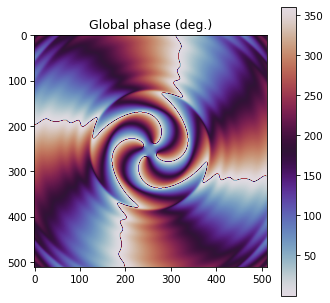

In [18]:
pol_parameters.parameters.global_phase(draw=True, verbose=False)

Delay between electric field components of from Diffractio is (deg.):
The mean value is 181.21222003934344 +- 66.73819681781413


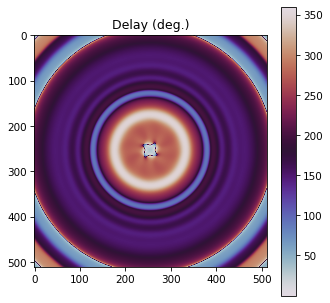

In [19]:
pol_parameters.parameters.delay(draw=True,verbose=False)

The azimuth and ellipticity angles of from Diffractio are (deg.):
The mean value of param Azimuth (deg.) is 123.73311677863424 +- 57.20212325637826
The mean value of param Ellipticity angle (deg.) is 2.5251069101626022 +- 13.118144387979036


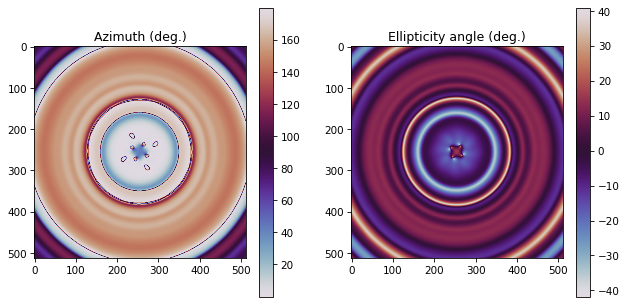

In [20]:
pol_parameters.parameters.azimuth_ellipticity(draw=True,verbose=False)

The degree of circular polarization of from Diffractio is:
The mean value is 0.08093184859394499 +- 0.40813939202128496


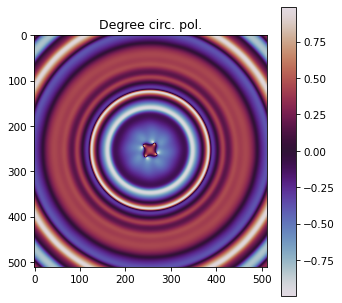

In [21]:
pol_parameters.parameters.degree_circular_polarization(draw=True,verbose=False)

The degree of linear polarization of from Diffractio is:
The mean value is 0.8974789840081703 +- 0.14630019079729625


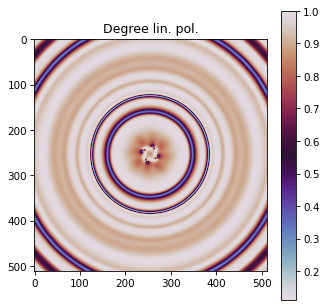

In [22]:
pol_parameters.parameters.degree_linear_polarization(draw=True,verbose=False)